In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Helper to make the output consistent
SEED = 42
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check TensorFlow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


## Import dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../mnist_data', validation_size=0)

Extracting ../mnist_data/train-images-idx3-ubyte.gz
Extracting ../mnist_data/train-labels-idx1-ubyte.gz
Extracting ../mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../mnist_data/t10k-labels-idx1-ubyte.gz


In [4]:
print(mnist.train.images.shape)

(60000, 784)


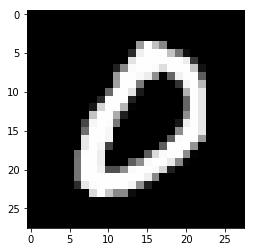

In [5]:
# display, random, single image
img = mnist.train.images[np.random.randint(6000, size=1)]

# mnist is 28x28 = 784 and is grayscale
# meaning, the 784 vector needs to be reshaped to 28,28
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Building the encoder

In [6]:
encoding_dim = 64
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")

# --- Model
# encoder
encoded = tf.layers.dense(input_vector, encoding_dim, activation=tf.nn.relu)

# decoder
logits = tf.layers.dense(encoded, img_vect_size, activation=None)
decoded = tf.nn.sigmoid(logits, name="output")

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=input_target, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()

In [7]:
epochs = 16
batch_size = 256
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/mlp_autoencoder")

E: 1/16 - loss: 0.6968
E: 2/16 - loss: 0.1672
E: 3/16 - loss: 0.1355
E: 4/16 - loss: 0.1115
E: 5/16 - loss: 0.1007
E: 6/16 - loss: 0.0916
E: 7/16 - loss: 0.0841
E: 8/16 - loss: 0.0804
E: 9/16 - loss: 0.0797
E: 10/16 - loss: 0.0784
E: 11/16 - loss: 0.0772
E: 12/16 - loss: 0.0755
E: 13/16 - loss: 0.0756
E: 14/16 - loss: 0.0777
E: 15/16 - loss: 0.0734
E: 16/16 - loss: 0.0753


## Restore session

In [8]:
save_path = "./saver/mlp_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

INFO:tensorflow:Restoring parameters from ./saver/mlp_autoencoder


### Run the model on a small test set

In [9]:
start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})
print("done")

done


### Visually inspect
The top row is the input (uncompressed) and the bottom row is the image encoded and decoded.

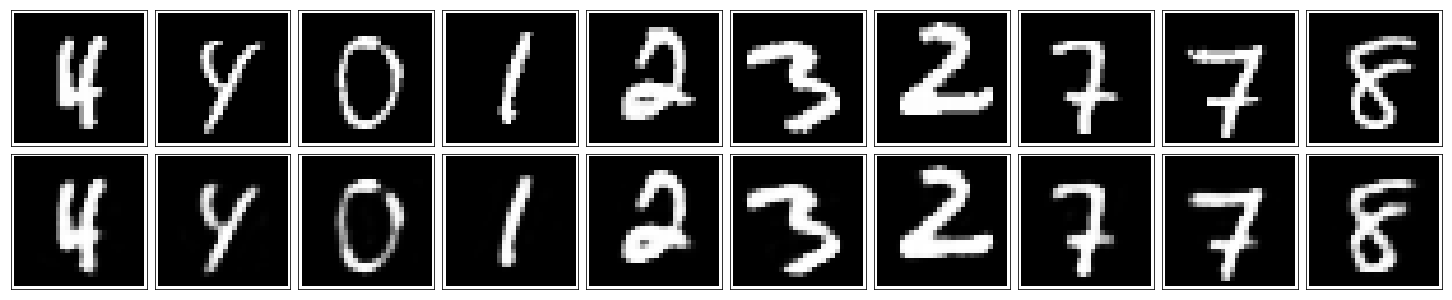

In [10]:
# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

In [ ]:
sess.close()